In [ ]:
# Tutorial
# https://pytorch.org/tutorials/intermediate/speech_command_recognition_with_torchaudio.html

In [ ]:
%matplotlib inline

In [ ]:
%%capture
!pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

from urllib.request import urlopen
import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm.notebook import tqdm

In [ ]:
# basic random seed
import os
import random
import numpy as np

DEFAULT_RANDOM_SEED = 2021

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

# tensorflow random seed
import tensorflow as tf

def seedTF(seed=DEFAULT_RANDOM_SEED):
    tf.random.set_seed(seed)

# torch random seed

def seedTorch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# basic + tensorflow + torch
def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    seedTF(seed)
    seedTorch(seed)

seedEverything(1004)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from torchaudio.datasets import SPEECHCOMMANDS
import os

class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return sorted([os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj])

        if subset == "testing":
            self._walker = load_list("testing_list.txt")
            test_list = [int(line) for line in urlopen('https://www.cse.iitb.ac.in/~pjyothi/cs753/test_list.txt')]
            self._walker = [self._walker[i] for i in test_list]
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w[2:] not in excludes]
            train_list = [int(line) for line in urlopen('https://www.cse.iitb.ac.in/~pjyothi/cs753/train_list.txt')]
            self._walker = [self._walker[i] for i in train_list]

# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

In [ ]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

In [ ]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))

def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]

In [ ]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)

def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [ ]:
class M11(nn.Module):                          # this is m11 architecture
    def __init__(self, n_input = 1, n_output =10):
        super(M11, self).__init__()
        self.conv1 = nn.Conv1d(n_input, 64, 80, 4)   #(in, out, filter size, stride)
        self.bn1 = nn.BatchNorm1d(64)          # this is used to normalize 
        self.pool1 = nn.MaxPool1d(4)

        self.conv2 = nn.Conv1d(64, 64, 3)      # by default, the stride is 1 if it is not specified here.
        self.bn2 = nn.BatchNorm1d(64)
        self.conv2b = nn.Conv1d(64, 64, 3)     # by default, the stride is 1 if it is not specified here.
        self.bn2b = nn.BatchNorm1d(64)
    
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(64, 128, 3)
        self.bn3 = nn.BatchNorm1d(128)
        self.conv3b = nn.Conv1d(128, 128, 3)
        self.bn3b = nn.BatchNorm1d(128)


        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(128, 256, 3)
        self.bn4 = nn.BatchNorm1d(256)
        self.conv4b = nn.Conv1d(256, 256, 3)
        self.bn4b = nn.BatchNorm1d(256)
        self.conv4c = nn.Conv1d(256, 256, 3)
        self.bn4c = nn.BatchNorm1d(256)

        self.pool4 = nn.MaxPool1d(4)
        self.conv5 = nn.Conv1d(256, 512, 3)
        self.bn5 = nn.BatchNorm1d(512)
        self.conv5b = nn.Conv1d(512, 512, 3)
        self.bn5b = nn.BatchNorm1d(512)

        # self.avgPool = nn.AvgPool1d(25)      #replaced with ADaptive + flatten
        self.avgPool = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, n_output)          # this is the output layer.

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.conv2b(x)
        x = F.relu(self.bn2b(x))

        x = self.pool2(x)
        
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.conv3b(x)
        x = F.relu(self.bn3b(x))

        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.conv4b(x)
        x = F.relu(self.bn4b(x))
        x = self.conv4c(x)
        x = F.relu(self.bn4c(x))

        x = self.pool4(x)
        x = self.conv5(x)
        x = F.relu(self.bn5(x))
        x = self.conv5b(x)
        x = F.relu(self.bn5b(x))

        x = self.avgPool(x)
        x = self.flatten(x) 
        x = self.fc1(x)                        # this is the output layer. [n,1, 10] i.e 10 probs for each audio files 
        return F.log_softmax(x, dim=1)

In [ ]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.2f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

In [ ]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()

def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)

def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.2f}%)\n")

In [ ]:
model = M11(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)  # reduce the learning after 20 epochs by a factor of 10

In [ ]:
log_interval = 20
n_epoch = 20

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

  0%|          | 0/20 [00:00<?, ?it/s]

Train Epoch: 1 [0/12000 (0.00%)]	Loss: 3.578741
Train Epoch: 1 [5120/12000 (42.55%)]	Loss: 3.144573
Train Epoch: 1 [10240/12000 (85.11%)]	Loss: 2.597869

Test Epoch: 1	Accuracy: 684/4000 (17.10%)

Train Epoch: 2 [0/12000 (0.00%)]	Loss: 2.204809
Train Epoch: 2 [5120/12000 (42.55%)]	Loss: 1.922959
Train Epoch: 2 [10240/12000 (85.11%)]	Loss: 1.861471

Test Epoch: 2	Accuracy: 1827/4000 (45.67%)

Train Epoch: 3 [0/12000 (0.00%)]	Loss: 1.409095
Train Epoch: 3 [5120/12000 (42.55%)]	Loss: 1.422021
Train Epoch: 3 [10240/12000 (85.11%)]	Loss: 1.228104

Test Epoch: 3	Accuracy: 1974/4000 (49.35%)

Train Epoch: 4 [0/12000 (0.00%)]	Loss: 1.178101
Train Epoch: 4 [5120/12000 (42.55%)]	Loss: 1.088124
Train Epoch: 4 [10240/12000 (85.11%)]	Loss: 0.967470

Test Epoch: 4	Accuracy: 2479/4000 (61.98%)

Train Epoch: 5 [0/12000 (0.00%)]	Loss: 0.941976
Train Epoch: 5 [5120/12000 (42.55%)]	Loss: 1.008926
Train Epoch: 5 [10240/12000 (85.11%)]	Loss: 0.881663

Test Epoch: 5	Accuracy: 2588/4000 (64.70%)

Train Epoch

In [ ]:
model.eval()
correct = 0

preds = []
true_labels =[]

for data, target in test_loader:

    data = data.to(device)
    target = target.to(device)

    # apply transform and model on whole batch directly on device
    data = transform(data)
    output = model(data)

    pred = get_likely_index(output)
    correct += number_of_correct(pred, target)

    preds.extend(pred.cpu().numpy())
    true_labels.extend(target.cpu().numpy())

    # update progress bar
    pbar.update(pbar_update)

print(f"{100. * correct / len(test_loader.dataset):.2f}")

77.72


In [ ]:
# assumed that we have access to test_loader and transform functions
# also the function for getting likely index from label
def find_confusion_matrix(model):

    model.eval()

    preds = []
    true_labels =[]

    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)

        preds.extend(pred.cpu().numpy())
        true_labels.extend(target.cpu().numpy())

        # update progress bar
        pbar.update(pbar_update)

    L = len(labels)
    T = len(true_labels)

    conf_matrix = np.zeros((L,L))
    for i in range(L):
        for j in range(L):
            conf_matrix[i, j] = np.sum([true_labels[k] == i and preds[k] == j for k in range(T)])

    conf_matrix /= conf_matrix.astype(float).sum(axis = 1)

    return conf_matrix

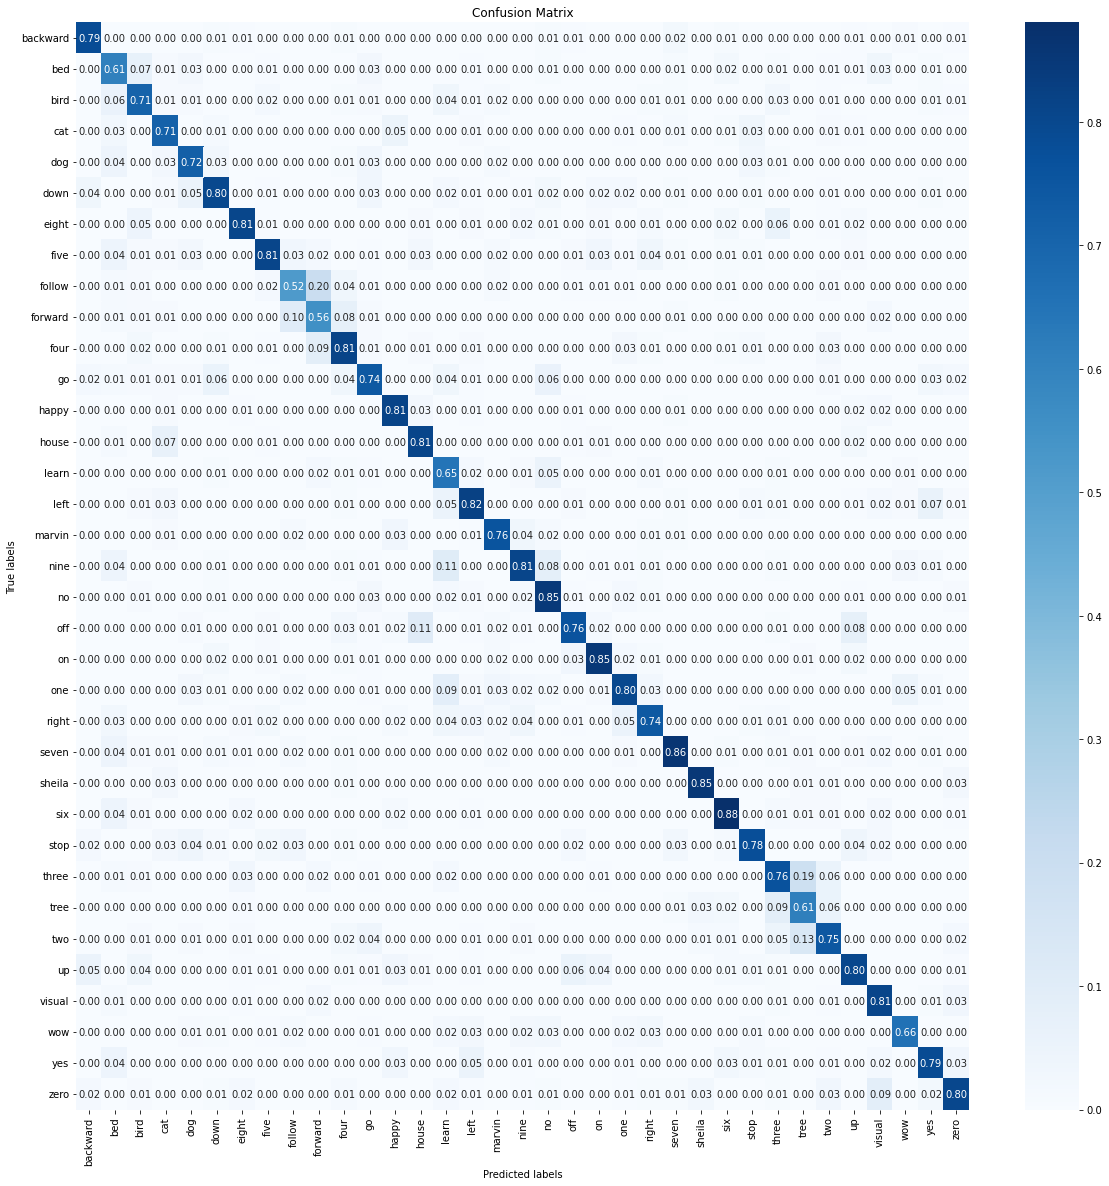

In [ ]:
import seaborn as sns

conf_matrix = find_confusion_matrix(model)

# create a list of class names to use as tick labels
class_names = labels

# create a figure with a specified size
plt.figure(figsize=(20, 20))

# use seaborn heatmap to plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='.2f', xticklabels=class_names, yticklabels=class_names)

# set the axis labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

plt.show()